<a href="https://colab.research.google.com/github/JuliaKoryukova/Machine-Learning/blob/main/06_%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%94%D0%B5%D1%80%D0%B5%D0%B2%D0%BE_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<font color='#11a642' size='6'>Алгоритм Дерево решений</font>  
  

Работа основана на данных активного конкурса на 11-07-2024 https://www.kaggle.com/competitions/playground-series-s4e7.

Описание данных https://www.kaggle.com/datasets/annantkumarsingh/health-insurance-cross-sell-prediction-data/discussion/516324

1. Загрузка данные c конкурса https://www.kaggle.com/competitions/playground-series-s4e7.
2. Разведочный анализ данных (EDA):  
3. Построение модели дерево решений
4. Загрузка решения на kaggle






# <font color='#11a642' size='6'> **Импорт и установка библиотек**

In [ ]:
!pip install category_encoders -q
!pip install kaggle -q
!pip install gdown -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import json
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV)
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (accuracy_score, classification_report)

%matplotlib inline

In [ ]:
my_random_state = 1

# <font color='#11a642' size='6'> **Загрузка данных**

In [ ]:
def load_dataset(from_kaggle=True) -> pd.DataFrame:
  if from_kaggle:
    drive.mount('/content/drive')
    !mkdir ~/.kaggle
    !cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
    !kaggle competitions download -c playground-series-s4e7
  else:
    !gdown 1HG4oNC-EfEK7DsXDfKKfb5BtgzevyZZO
  zip_ref = zipfile.ZipFile('playground-series-s4e7.zip', 'r')
  zip_ref.extractall()
  zip_ref.close()
  df_train = pd.read_csv('train.csv')
  df_test = pd.read_csv('test.csv')
  df_sample_submission = pd.read_csv('sample_submission.csv')
  return df_train, df_test, df_sample_submission

In [ ]:
df_train, df_test, df_sample_submission = load_dataset(from_kaggle=True)

Mounted at /content/drive
 99% 245M/247M [00:04<00:00, 66.1MB/s]
100% 247M/247M [00:04<00:00, 56.9MB/s]


In [ ]:
# это данные даны для примера, в таком виде необходимо сделать выборку и загрузить на kaggle
df_sample_submission.head()

,id,Response
0,11504798,0.5
1,11504799,0.5
2,11504800,0.5
3,11504801,0.5
4,11504802,0.5


In [ ]:
# это тестовые данные, для которых необходимо предсказать target, то есть применить модель,
#  которая будет разработана на данных df_train
df_test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271
3,11504801,Female,22,1,47.0,1,< 1 Year,No,24502.0,152.0,115
4,11504802,Male,51,1,19.0,0,1-2 Year,No,34115.0,124.0,148


In [ ]:
# на этих данных дальше необходимо разработать модель
df_train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


## <font color='#11a642' size='5'> Определим роли для независимых признаков

In [ ]:
id = 'id'
target = 'Response'
features_cat_from_description = ['Region_Code', 'Vehicle_Age', 'Policy_Sales_Channel']

In [ ]:
features_num = [feature for feature in df_train.select_dtypes(include='number').columns.to_list()
               if feature not in [id, target, *features_cat_from_description]]
features_num

['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium', 'Vintage']

In [ ]:
features_cat = [feature for feature in df_train.columns.to_list() if feature
                not in [id, target, *features_num]]
features_cat

['Gender',
 'Region_Code',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Policy_Sales_Channel']

In [ ]:
features_cat_bin = ['Gender', ]

# <font color='#11a642' size='6'> **Разведочный анализ данных**

## <font color='#11a642' size='5'> Оценка размера датасета


1.   Сколько ГБ датасет
2.   Сколько строк и столбцов



In [ ]:
# Сколько ГБ датасет
size_byte_train = df_train.memory_usage(index=True).sum()
size_gb_train = size_byte_train / (1024 ** 3)

size_byte_test = df_test.memory_usage(index=True).sum()
size_gb_test = size_byte_test / (1024 ** 3)

summa_size_df = size_gb_train + size_gb_test

print(f"The dataset df_train is {size_gb_train:.2f} GB")
print(f"The dataset df_test is {size_gb_test:.2f} GB")
print(f"The datasets df_train + df_test are {summa_size_df:.2f} GB")

The dataset df_train is 1.03 GB
The dataset df_test is 0.63 GB
The datasets df_train + df_test are 1.66 GB


In [ ]:
# Сколько строк и столбцов
df_train.shape, df_test.shape

((11504798, 12), (7669866, 11))

## <font color='#11a642' size='5'> Анализ категориальных признаков


In [ ]:
df_train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [ ]:
category_cols = [col for col, dtype in df_train.dtypes.items() if dtype.name == 'object']
category_cols

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [ ]:
df_train.Gender.value_counts()

Gender
Male      6228134
Female    5276664
Name: count, dtype: int64

In [ ]:
df_train.Vehicle_Age.value_counts()

Vehicle_Age
1-2 Year     5982678
< 1 Year     5044145
> 2 Years     477975
Name: count, dtype: int64

In [ ]:
df_train.Vehicle_Damage.value_counts()

Vehicle_Damage
Yes    5783229
No     5721569
Name: count, dtype: int64

## <font color='#11a642' size='5'> Анализ пропусков


In [ ]:
df_train.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

# <font color='#11a642' size='6'> **Разделение данных на трейн и тест**

In [ ]:
%%time
X_train, X_test, y_train, y_test = train_test_split(df_train[[*features_cat, *features_num]],
                                                    df_train[target],
                                                    test_size=0.2,
                                                    stratify=df_train[target],
                                                    random_state=my_random_state)
X_train.shape, X_test.shape

CPU times: user 11.9 s, sys: 1.86 s, total: 13.8 s
Wall time: 15.8 s


((9203838, 10), (2300960, 10))

# <font color='#11a642' size='6'> **Подготовка данных к обучению**



1.   Обработка категориальных переменных
2.   Обработка пропусков
3.   Стоит ли делать нормализацию данных?



In [ ]:
# Mean target encoding для категориальных признаков
target_enc = TargetEncoder(cols=features_cat)

X_train[features_cat] = target_enc.fit_transform(X_train[features_cat], y_train)
X_test[features_cat] = target_enc.transform(X_test[features_cat])

# Стандартизация признаков
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)


In [ ]:
X_train_df = pd.DataFrame(X_train_scaler, columns = [col for col in df_train.columns if col not in ['Response', 'id']])
X_test_df = pd.DataFrame(X_test_scaler, columns = [col for col in df_test.columns if col not in ['Response', 'id']])

In [ ]:
X_train_df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,-1.086346,-1.186203,0.721236,-1.005426,0.778629,0.174337,0.044604,1.076945,-0.392496,-0.536356
1,-1.086346,1.393366,0.721236,0.994603,0.950420,0.174337,0.044604,-0.928553,-0.131349,0.601432
2,-1.086346,0.082981,-1.075033,-1.005426,-1.084688,-0.359180,0.044604,1.076945,-0.198520,1.051546
3,-1.086346,0.141623,-1.075033,-1.005426,-1.084688,-0.826007,0.044604,1.076945,0.316906,0.889005
4,-1.086346,-0.711785,0.721236,0.994603,1.995342,2.641852,0.044604,-0.928553,-1.691669,-0.198771
...,...,...,...,...,...,...,...,...,...,...
9203833,-1.086346,1.393366,0.721236,0.994603,0.950420,0.774543,0.044604,-0.928553,2.276729,1.476654
9203834,-1.086346,-1.042799,-1.075033,0.994603,-1.084688,-0.959386,0.044604,-0.928553,-0.109282,0.338866
9203835,-1.086346,1.393366,0.721236,-1.005426,0.778629,0.707854,0.044604,1.076945,2.504443,-0.923954
9203836,0.920517,-0.711785,-1.075033,-1.005426,-1.084688,-0.959386,0.044604,1.076945,-0.040348,-0.461337


# <font color='#11a642' size='6'> **Построение модели дерево решений**

## <font color='#11a642' size='5'> Построение максимального дерева без ограничений на гиперпараметры


In [ ]:
dt = DecisionTreeClassifier(random_state = my_random_state)
dt.fit(X_train_df, y_train)

DecisionTreeClassifier(random_state=1)

### <font color='#11a642' size='4'> Оценка качества  максимального дерева без ограничений на гиперпараметры


In [ ]:
# Получение предсказанных меток классов на тестовой выборке
y_pred_test = dt.predict(X_test_df)
y_pred_train = dt.predict(X_train_df)

# Вычисление точности
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)

print(f'Decision tree accuracy test: {accuracy_test:.2f}')
print(f'Decision tree accuracy train: {accuracy_train:.2f}')

Decision tree accuracy test: 0.83
Decision tree accuracy train: 1.00


Вывод:

Модель переобучена. Нужно искать гиперпараметры.

## <font color='#11a642' size='5'> Построение дерева с поиском наилучших гиперапарметров


In [ ]:
# Создание случайной подвыборки
X_train_df_sample = X_train_df.sample(frac=0.1, random_state=my_random_state).reset_index(drop=True)
X_test_df_sample = X_test_df.sample(frac=0.1, random_state=my_random_state).reset_index(drop=True)

y_train_sample = y_train.sample(frac=0.1, random_state=my_random_state).reset_index(drop=True)
y_test_sample = y_test.sample(frac=0.1, random_state=my_random_state).reset_index(drop=True)

X_train_df_sample.shape, X_test_df_sample.shape, y_train_sample.shape, y_test_sample.shape

((920384, 10), (230096, 10), (920384,), (230096,))

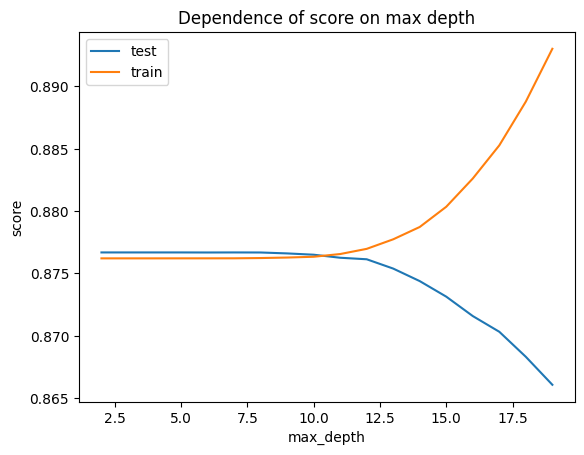

In [ ]:
# Параметр максимальная глубина
max_depth_array = range(2, 20)
score_depth_test = []
score_depth_train = []

for max_depth in max_depth_array:
  dt = DecisionTreeClassifier(max_depth=max_depth, random_state=my_random_state)
  dt.fit(X_train_df_sample, y_train_sample)
  score_depth_test.append(accuracy_score(y_test_sample, dt.predict(X_test_df_sample)))
  score_depth_train.append(accuracy_score(y_train_sample, dt.predict(X_train_df_sample)))

plt.plot(max_depth_array, score_depth_test, label='test')
plt.plot(max_depth_array, score_depth_train, label='train')
plt.title('Dependence of score on max depth')
plt.xlabel('max_depth')
plt.ylabel('score')
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({'max_depth': max_depth_array, 'score': score_depth_test}).sort_values(by='score').reset_index(drop=True).sort_values('max_depth')

,max_depth,score
17,2,0.877238
16,3,0.877238
15,4,0.877234
14,5,0.877234
13,6,0.877230
11,7,0.877203
12,8,0.877208
10,9,0.877147
9,10,0.877086
8,11,0.877030


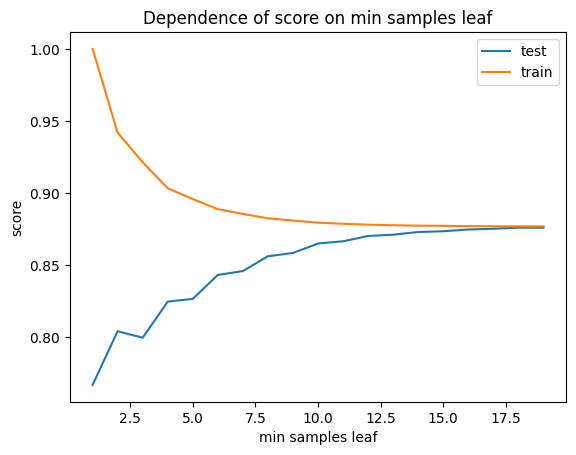

In [ ]:
# Минимальный размер листа
min_leaf_array = range(1, 20)
score_leaf_test = []
score_leaf_train = []

for min_leaf in min_leaf_array:
  dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=min_leaf, random_state=my_random_state)
  dt.fit(X_train_df_sample, y_train_sample)
  score_leaf_test.append(accuracy_score(y_test_sample, dt.predict(X_test_df_sample)))
  score_leaf_train.append(accuracy_score(y_train_sample, dt.predict(X_train_df_sample)))

plt.plot(min_leaf_array, score_leaf_test, label='test')
plt.plot(min_leaf_array, score_leaf_train, label='train')
plt.title("Dependence of score on min samples leaf")
plt.xlabel("min samples leaf")
plt.ylabel("score")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({'min_leaf': min_leaf_array, 'score': score_leaf_test}).sort_values(by='score').reset_index(drop=True).sort_values('min_leaf')

,min_leaf,score
0,1,0.767128
2,2,0.804325
1,3,0.799844
3,4,0.824869
4,5,0.826768
5,6,0.843348
6,7,0.846047
7,8,0.856308
8,9,0.858581
9,10,0.865148


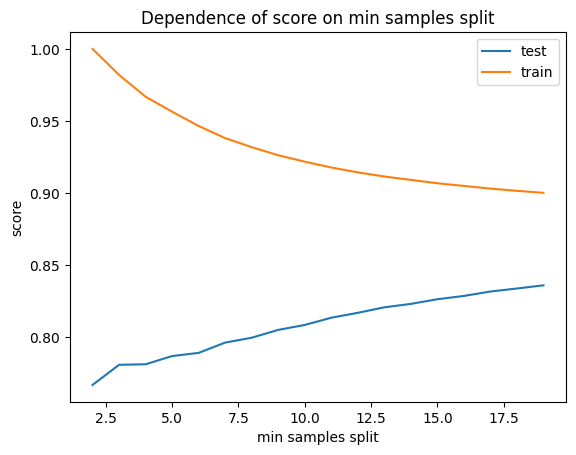

In [ ]:
# Минимальный размер узла, который можно разделить
min_split_array = range(2, 20)
score_split_test = []
score_split_train = []

for min_split in min_split_array:
  dt = DecisionTreeClassifier(
      max_depth=None, min_samples_split=min_split, random_state=my_random_state
  )
  dt.fit(X_train_df_sample, y_train_sample)
  score_split_test.append(accuracy_score(y_test_sample, dt.predict(X_test_df_sample)))
  score_split_train.append(accuracy_score(y_train_sample, dt.predict(X_train_df_sample)))

plt.plot(min_split_array, score_split_test, label='test')
plt.plot(min_split_array, score_split_train, label='train')
plt.title("Dependence of score on min samples split")
plt.xlabel("min samples split")
plt.ylabel("score")
plt.legend()
plt.show()

In [ ]:
pd.DataFrame({'min_split': min_split_array, 'score': score_split_test}).sort_values(by='score').reset_index(drop=True).sort_values('min_split')

,min_split,score
0,2,0.767128
1,3,0.781078
2,4,0.781448
3,5,0.787137
4,6,0.789344
5,7,0.796472
6,8,0.799840
7,9,0.805264
8,10,0.808702
9,11,0.813699


In [ ]:
# RandomizedSearchCV

# инициализация модели
df = DecisionTreeClassifier(random_state=my_random_state)

# параметры перебора по сетке
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [2, 5, 10, 15]
}

In [ ]:
%%time
# инициализация RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    estimator=df,
    param_distributions=param_grid,
    n_jobs=-1,
    scoring='accuracy',
    cv=5,
    verbose=2,
)

# перебор параметров, обучение модели, и сохранение лучшей модели и ее метрик качества
randomized_search.fit(X_train_df_sample, y_train_sample)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 5.1 s, sys: 850 ms, total: 5.95 s
Wall time: 3min 51s


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 5, 10, 15, 20],
                                        'min_samples_leaf': [2, 5, 10, 15],
                                        'min_samples_split': [2, 5, 10, 15]},
                   scoring='accuracy', verbose=2)

In [ ]:
print(f'Лучшие найденные параметры для модели:\n{randomized_search.best_params_}')
print(f'Лучшая метрика на этих параметрах:{randomized_search.best_score_}')

Лучшие найденные параметры для модели:
{'min_samples_split': 10, 'min_samples_leaf': 15, 'max_depth': 10, 'criterion': 'entropy'}
Лучшая метрика на этих параметрах:0.8761679908018627


In [ ]:
# Функция для расчета и печати метрик
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

def print_metrics(model, x, y):
    y_pred = model.predict(x)
    print(f'Accuracy: {accuracy_score(y, y_pred):.4f}')

    # balanced_accuracy_score вычисляет и усредняет accuracy отдельно по каждому классу - актуально при дисбалансе классов
    print(f'Balanced Accuracy: {balanced_accuracy_score(y, y_pred):.4f}')

    # параметр weighted - усреднение метрики с использованием весов, пропорциональных размеру каждого класса - актуально при дисбалансе классов
    print(f'F1 Score: {f1_score(y, y_pred, average="weighted"):.4f}')

In [ ]:
# получить модель с лучшими параметрами
best_dt = randomized_search.best_estimator_

print_metrics(best_dt, X_test_df, y_test)

Accuracy: 0.8770
Balanced Accuracy: 0.5000
F1 Score: 0.8195


### <font color='#11a642' size='4'> Оценка качества  дерева с оптимальными гиперпараметрами


In [ ]:
dt = DecisionTreeClassifier(**randomized_search.best_params_)

k = 5
scores = cross_val_score(dt, X_train_df, y_train, cv=k, scoring='accuracy')

# Выводим результаты кросс-валидации
print("Scores:", scores)
print("Mean Accuracy:", np.mean(scores))

Scores: [0.87700297 0.87700243 0.87700243 0.8770029  0.8770029 ]
Mean Accuracy: 0.8770027242983149


In [ ]:
# Вычисление среднего значения
mean_value = np.mean(scores)

# Вычисление дисперсии
variance = np.var(scores)

print("Среднее значение:", mean_value)
print("Дисперсия:", variance)

Среднее значение: 0.8770027242983149
Дисперсия: 6.02851197306204e-14


### <font color='#11a642' size='4'> Важность признаков для дерева с оптимальными гиперпараметрами


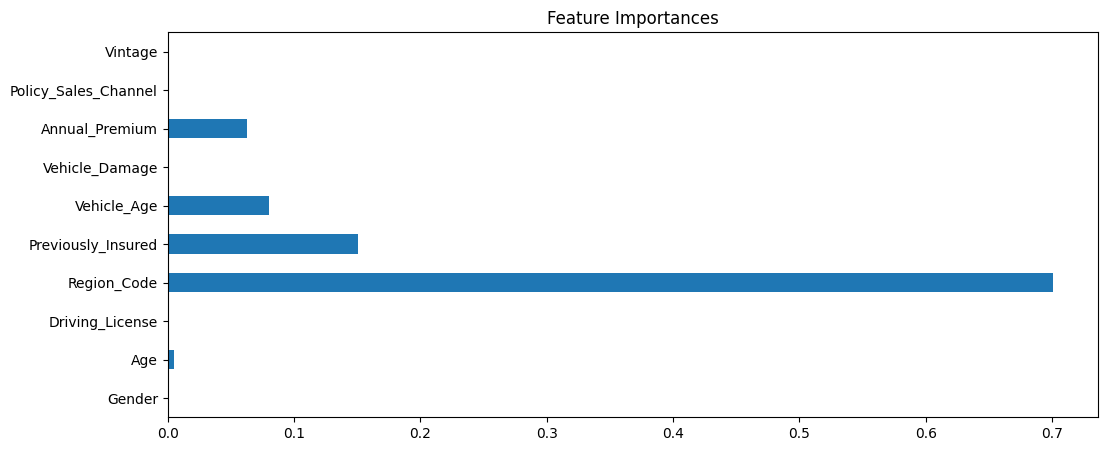

In [ ]:
dt = DecisionTreeClassifier(max_depth=5, random_state=my_random_state)
dt.fit(X_train_df, y_train)
# извленчение важности признаков и создание серии чтобы удобно отрисовать
feature_importances = pd.Series(dt.feature_importances_, X_train_df.columns)

# отрисовка важности признаков
plt.title('Feature Importances')
feature_importances.plot(kind='barh', figsize=(12, 5))
plt.show()

In [ ]:
dt.feature_importances_

array([0.00000000e+00, 5.01696358e-03, 0.00000000e+00, 7.01057091e-01,
       1.50992851e-01, 7.99101026e-02, 0.00000000e+00, 6.30228596e-02,
       6.16198232e-08, 7.08066262e-08])

In [ ]:
pd.DataFrame(
    {"feature": X_train_df.columns, "importance": dt.feature_importances_}
).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,Region_Code,7.010571e-01
1,Previously_Insured,1.509929e-01
2,Vehicle_Age,7.991010e-02
3,Annual_Premium,6.302286e-02
4,Age,5.016964e-03
5,Vintage,7.080663e-08
6,Policy_Sales_Channel,6.161982e-08
7,Gender,0.000000e+00
8,Driving_License,0.000000e+00
9,Vehicle_Damage,0.000000e+00


### <font color='#11a642' size='4'> Рисую дерево с оптимальными гиперпараметрами


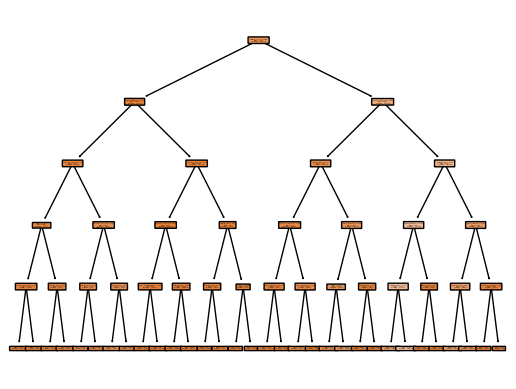

In [ ]:
plot_tree(dt, feature_names=X_train_df.columns, filled=True, rounded=True)
plt.show()

In [ ]:
text_representation = export_text(dt)
print(text_representation)

|--- feature_3 <= -0.01
|   |--- feature_7 <= 0.07
|   |   |--- feature_4 <= 1.39
|   |   |   |--- feature_1 <= -0.45
|   |   |   |   |--- feature_4 <= 0.56
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_4 >  0.56
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_1 >  -0.45
|   |   |   |   |--- feature_5 <= 0.14
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5 >  0.14
|   |   |   |   |   |--- class: 0
|   |   |--- feature_4 >  1.39
|   |   |   |--- feature_4 <= 1.53
|   |   |   |   |--- feature_5 <= 0.07
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5 >  0.07
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_4 >  1.53
|   |   |   |   |--- feature_5 <= 0.94
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_5 >  0.94
|   |   |   |   |   |--- class: 0
|   |--- feature_7 >  0.07
|   |   |--- feature_4 <= 1.42
|   |   |   |--- feature_4 <= 0.55
|   |   |   |   |--- feature_8 <= -0.48
|   |   |   |   |   |--- cla

# <font color='#11a642' size='6'> **Применение алгоритма к тестовой выборке df_test и сабмит решения на kaggle**

In [ ]:
df_test_enc = df_test.copy()
df_test_enc.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271


In [ ]:
df_test_enc = df_test.copy()

y_pred_test_full = best_dt.predict_proba(X_test_df)[:, 1]

# Создание файла для сабмита на Kaggle
df_test['Response'] = y_pred_test_full[0]
submission = df_test[[id, 'Response']]
submission.to_csv('/content/submissions.csv', index=False)

print(submission.head())

# Загрузка результатов на Kaggle
from google.colab import drive
drive.mount('/content/drive')
!pip install kaggle -q
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/config/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions submit -c playground-series-s4e7 -f /content/submissions.csv -m "tree submit"

         id  Response
0  11504798  0.336791
1  11504799  0.336791
2  11504800  0.336791
3  11504801  0.336791
4  11504802  0.336791
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 205M/205M [00:02<00:00, 95.7MB/s]
Successfully submitted to Binary Classification of Insurance Cross Selling 